In [29]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from IPython.display import display, clear_output

import plotly.express as px

import matplotlib.pyplot as plt
import plotly.io as pio

import seaborn as sns

import plotly.graph_objects as go

In [30]:
pio.renderers.default = "iframe_connected"

In [35]:
pio.renderers.default = "notebook_connected"

In [ ]:

import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, pipeline

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

from nltk.util import ngrams



import pandas as pd

In [5]:
df_combined = pd.read_csv("../aggregated_data/combined_review_data.csv")

In [ ]:
df_combined.head()

In [ ]:
df_combined.info()

In [ ]:
df_combined.shape

## Sentiment Analysis

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [ ]:

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

In [ ]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}


In [ ]:
def safe_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "Neutral"
    try:
        # Truncate input text at tokenizer level
        result = sentiment_analyzer(
            text,
            truncation=True,
            max_length=512
        )[0]
        return label_map.get(result['label'], "UNKNOWN")
    except Exception as e:
        print(f"Error processing text: {e}")
        return "ERROR"

In [ ]:
df_combined['sentiment'] = df_combined['review'].apply(safe_sentiment)

In [ ]:
df_combined['sentiment'].value_counts()

In [ ]:

df_combined.to_csv("../aggregated_data/combined_review_data_with_sentiment.csv", index=False)


In [26]:


df_combined = pd.read_csv('../aggregated_data/combined_review_data_with_sentiment.csv')

## Sentiment Distribution for Apps

In [ ]:


def plot_sentiment_distribution(selected_app):
    # Filter your dataframe based on app
    filtered_df = df_combined[df_combined['app_name'] == selected_app]

    # Get sentiment counts
    sentiment_counts = filtered_df['sentiment'].value_counts()

    # Plotting donut chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        sentiment_counts,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops=dict(width=0.4)  # Makes it a donut
    )

    ax.set_title(f'Sentiment Distribution for {selected_app}')
    plt.show()

### Sentiment Distribution for UberEats

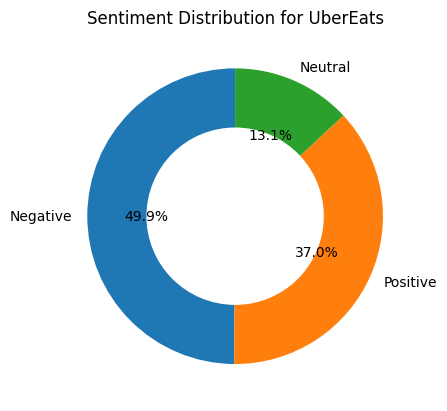

In [37]:
#| echo: true
plot_sentiment_distribution('UberEats')

### Sentiment Distribution for DoorDash

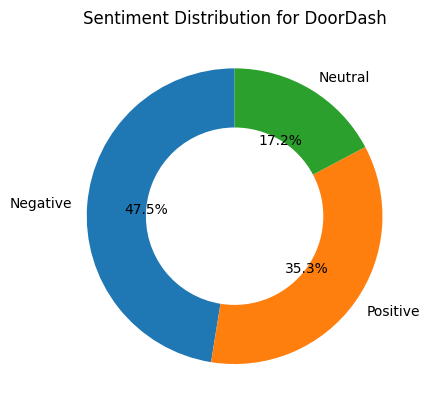

In [38]:
#| echo: true
plot_sentiment_distribution('DoorDash')

### Sentiment Distribution for Grubhub

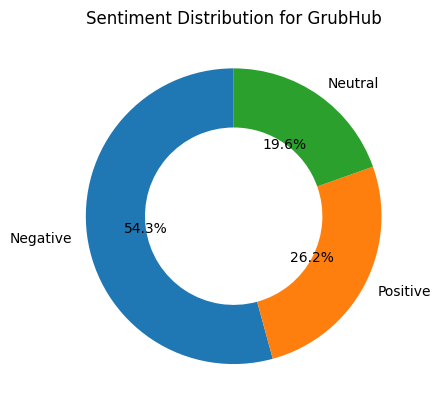

In [39]:
#| echo: true
plot_sentiment_distribution('GrubHub')

 The donut chart above illustrates the sentiment distribution of customer reviews for food delivery apps. Each segment of the chart represents the percentage of reviews that are classified as Positive, Neutral, or Negative. This visualization offers a clear and comparative view of user satisfaction levels, highlighting how customer perception varies across different apps.

## Sentiment Distribution for Data Sources

In [40]:
#| echo: true


# ---------------------------
# Clean your data
# ---------------------------
df_combined['sentiment'] = df_combined['sentiment'].str.lower()
df_combined['data_source'] = df_combined['data_source'].str.strip().str.title()

# ---------------------------
# Define sentiment colors
# ---------------------------
sentiment_colors = {
    'neutral': '#90EE90',
    'positive': '#32CD32',
    'negative': '#006400',
}

# ---------------------------
# Setup
# ---------------------------
sources = sorted(df_combined['data_source'].unique())
sentiments = ['neutral', 'positive', 'negative']
fig = go.Figure()
buttons = []

# Create a donut chart for each data source
for i, src in enumerate(sources):
    filtered_df = df_combined[df_combined['data_source'] == src]
    counts = filtered_df['sentiment'].value_counts()
    values = [counts.get(s, 0) for s in sentiments]
    colors = [sentiment_colors[s] for s in sentiments]

    # Add a pie (donut) chart trace for this source
    fig.add_trace(go.Pie(
        labels=sentiments,
        values=values,
        hole=0.5,
        marker=dict(colors=colors),
        name=src,
        visible=(i == 0),
        textinfo='percent+label',
        insidetextorientation='radial'
    ))

    # Create button to toggle visibility
    buttons.append(dict(
        label=src,
        method="update",
        args=[{"visible": [j == i for j in range(len(sources))]},
              {"title": f"Overall Sentiment Distribution for {src}"}]
    ))

# ---------------------------
# Add dropdown menu
# ---------------------------
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        buttons=buttons,
        direction="down",
        x=0.1,
        y=1.15
    )],
    title=f"Overall Sentiment Distribution for {sources[0]}",
    height=500
)

fig.show()


 The donut chart visualizes the sentiment distribution for a selected app across various review platforms.Each segment of the chart represents the percentage of reviews labeled as Positive, Neutral, or Negative. This allows for comparison of user sentiment trends across different communities and platforms where the app is reviewed.

## Top 10 Upvoted Reviews for Apps

In [41]:
#| echo: true


df_combined['sentiment'] = df_combined['sentiment'].str.capitalize()
df_combined['review'] = df_combined['review'].astype(str)

# Define colors
sentiment_colors = {
    'Positive': 'green',
    'Negative': 'red',
    'Neutral': 'blue'
}

# Apps to show
apps = ['UberEats', 'DoorDash', 'GrubHub']

# Build the figure
fig = go.Figure()
buttons = []

for i, app in enumerate(apps):
    app_df = df_combined[df_combined['app_name'] == app]
    top_10 = app_df.sort_values(by='upvote_count', ascending=False).head(10)
    if top_10.empty:
        continue

    # Shorten long reviews
    review_labels = top_10['review'].apply(lambda x: x[:80] + '...' if len(x) > 80 else x)
    bar_colors = top_10['sentiment'].map(sentiment_colors).fillna('gray')

    fig.add_trace(go.Bar(
        x=top_10['upvote_count'],
        y=review_labels,
        orientation='h',
        marker_color=bar_colors,
        name=app,
        visible=(i == 0),
        hovertext=top_10['review'],
    ))

    # Dropdown button to toggle visibility
    buttons.append(dict(
        label=app,
        method="update",
        args=[
            {"visible": [j == i for j in range(len(apps))]},
            {"title": f"Top 10 Upvoted Reviews for {app}"}
        ]
    ))

# Final layout
fig.update_layout(
    title=f"Top 10 Upvoted Reviews for {apps[0]} ",
    xaxis_title="Upvote Count",
    yaxis_title="Review",
    yaxis=dict(autorange='reversed'),
    height=600,
    updatemenus=[dict(
        type="dropdown",
        buttons=buttons,
        x=0.1,
        y=1.15
    )]
)

fig.show()


This horizontal bar chart displays the top 10 most upvoted customer reviews for a selected food delivery app. Each bar is color-coded by sentiment—blue for Neutral, red for Negative, and green (if present) for Positive—providing a quick visual reference to the tone of each review. The dropdown allows switching between UberEats, DoorDash, and GrubHub for comparison.

## Top 10 Upvoted Reviews for Data Sources

In [42]:
#| echo: true


# -----------------------------
# Clean data
# -----------------------------
df_combined['sentiment'] = df_combined['sentiment'].str.capitalize()
df_combined['review'] = df_combined['review'].astype(str)
df_combined['data_source'] = df_combined['data_source'].str.strip().str.title()

# -----------------------------
# Define sentiment colors
# -----------------------------
sentiment_colors = {
    'Positive': 'green',
    'Negative': 'red',
    'Neutral': 'blue'
}

# -----------------------------
# Limit to Reddit and Google Play
# -----------------------------
valid_sources = ['Reddit', 'Google Play']
sources = [s for s in valid_sources if s in df_combined['data_source'].unique()]

# -----------------------------
# Build Plotly figure
# -----------------------------
fig = go.Figure()
buttons = []

for i, source in enumerate(sources):
    source_data = df_combined[df_combined['data_source'] == source]
    top_10 = source_data.sort_values(by='upvote_count', ascending=False).head(10)

    review_labels = top_10['review'].apply(lambda x: x[:80] + '...' if len(x) > 80 else x)
    bar_colors = top_10['sentiment'].map(sentiment_colors).fillna('gray')

    fig.add_trace(go.Bar(
        x=top_10['upvote_count'],
        y=review_labels,
        orientation='h',
        marker_color=bar_colors,
        name=source,
        visible=(i == 0),
        hovertext=top_10['review'],
    ))

    buttons.append(dict(
        label=source,
        method="update",
        args=[
            {"visible": [j == i for j in range(len(sources))]},
            {"title": f"Top 10 Upvoted Reviews for {source}"}
        ]
    ))

# -----------------------------
# Final layout
# -----------------------------
fig.update_layout(
    title=f"Top 10 Upvoted Reviews for {sources[0]}" if sources else "No Data",
    xaxis_title="Upvote Count",
    yaxis_title="Review",
    yaxis=dict(autorange='reversed'),
    height=600,
    updatemenus=[dict(
        type="dropdown",
        buttons=buttons,
        x=0.1,
        y=1.15
    )]
)

fig.show()


This horizontal bar chart displays the top 10 most upvoted customer reviews from the selected data source. Users can switch between platforms such as Google Play and Reddit using the dropdown. Each bar represents a highly upvoted review and is color-coded by sentiment — red for Negative, blue for Neutral, and green for Positive. This plot highlights not only the most talked-about experiences on each platform but also the general sentiment users express toward food delivery apps depending on where the review was posted.